In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import glob
%matplotlib inline
# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm  # For a nice progress bar!
from time import time  # For measuring time
import statsmodels.api as sm


In [2]:
data_path = 'dataset/Azure/vm_cpu_readings-file-*-of-195.csv'
choiced_size = 5
choiced_csv = 3
headers=['timestamp','vmid','mincpu','maxcpu', 'avgcpu']
csv_files = sorted(glob.glob('dataset/Azure/vm_cpu_readings-file-*-of-195.csv'))

sample_df = pd.read_csv(csv_files[0], header=None, names=headers, delimiter=',')
all_vmids = sample_df['vmid'].unique()
selected_vmids = np.random.choice(all_vmids, size=choiced_size, replace=False)  # 选5个vmid，可自行调整
selected_data = []
for file in csv_files[:choiced_csv]: 
    df = pd.read_csv(file, header=None, names=headers)
    df_selected = df[df['vmid'].isin(selected_vmids)]
    if not df_selected.empty:
        selected_data.append(df_selected)
trace_dataframe = pd.concat(selected_data, ignore_index=True)
# trace_dataframe = pd.read_csv(data_path, header=None, index_col=False,names=headers,delimiter=',')
# find howmany unique vmid is in the dataset
unique_vms = trace_dataframe['vmid'].unique()
print(f"Number of unique VMs: {len(unique_vms)}")
print(f"Number of rows in the dataset: {len(trace_dataframe)}")
trace_dataframe.head()

Number of unique VMs: 5
Number of rows in the dataset: 669


,timestamp,vmid,mincpu,maxcpu,avgcpu
0,0,tffFHGT8WhcgTtpZTtEuWXH9DEbSKi3kVUm+yc/5ctglF2...,1.969749,2.662166,2.309368
1,0,M/FO/LkuA2qaAqmhaasbi8aOD7hYXykSfWKsP/kjn5SdFf...,2.000598,3.173453,2.435890
2,0,mCAui7sssHT5uOlkQTp+0kjBfTsPRB4uonJcrm6O5v9+HD...,2.127072,4.944519,2.742523
3,0,wB1ySZgZIfXqLaMJWZOMiQTLKmR3sJIyrlonNF8S5CAuKx...,0.741388,1.563128,0.977610
4,0,/NnxQ5ojOp4VBU1ZHCRWEXMQ+JakAq2Dha7jk0rc3J2vzI...,4.662349,47.165550,13.718614


In [3]:
# 只用5个vm的数据暂时
def generate_cpu_series(trace_dataframe, vmid):
    """
    Generate a CPU series for a specific VM ID.
    """
    cpu_series = trace_dataframe[trace_dataframe['vmid'] == vmid]['avgcpu'].values.astype(np.float32)
    return cpu_series
# vmid = trace_dataframe['vmid'].unique()[0]
# cpu_series = trace_dataframe[trace_dataframe['vmid']==vmid]['avgcpu'].values.astype(np.float32)
# print(f"Number of CPU readings for VM {vmid}: {len(cpu_series)}")
# # 标准化
# mean, std = cpu_series.mean(), cpu_series.std()
# cpu_series = (cpu_series - mean) / std


In [4]:
# 构造序列数据
SEQ_LEN = 20
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)
X, y = [], []
mean, std = trace_dataframe['avgcpu'].values.astype(np.float32).mean(), trace_dataframe['avgcpu'].values.astype(np.float32).std()

for vmid in selected_vmids:
    cpu_series = generate_cpu_series(trace_dataframe, vmid)
    print(f"Number of CPU readings for VM {vmid}: {len(cpu_series)}")
    # 标准化
    cpu_series = (cpu_series - mean) / std
    # 生成序列数据
    tmp_x, tmp_y = create_sequences(cpu_series, SEQ_LEN)
    X = X + tmp_x.tolist()
    y = y + tmp_y.tolist()
# X, y = create_sequences(cpu_series, SEQ_LEN)
print(len(X))
# 划分训练测试集
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).unsqueeze(-1)  # [batch, seq_len, 1]
        self.y = torch.tensor(y).unsqueeze(-1)  # [batch, 1]
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TimeSeriesDataset(X_train, y_train)
test_ds = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)


Number of CPU readings for VM tffFHGT8WhcgTtpZTtEuWXH9DEbSKi3kVUm+yc/5ctglF2s/CKqLdw4OW0XNA1hC: 135
Number of CPU readings for VM M/FO/LkuA2qaAqmhaasbi8aOD7hYXykSfWKsP/kjn5SdFfNh3Pv1lmV6hfw0JqpU: 134
Number of CPU readings for VM /NnxQ5ojOp4VBU1ZHCRWEXMQ+JakAq2Dha7jk0rc3J2vzIfwvlxRsW+yJbFd6wiW: 133
Number of CPU readings for VM wB1ySZgZIfXqLaMJWZOMiQTLKmR3sJIyrlonNF8S5CAuKxHQ653zIh4O5zD/ud2r: 134
Number of CPU readings for VM mCAui7sssHT5uOlkQTp+0kjBfTsPRB4uonJcrm6O5v9+HDZiuZoCHotg6okCN55D: 133
569


In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # 取最后一个时间步
        return self.fc(out)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out


# Recurrent neural network with GRU (many-to-one)
class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out


# Recurrent neural network with LSTM (many-to-one)
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(
            x, (h0, c0)
        )  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
lstm_training_start_time = time()
for epoch in range(500):
    model.train()
    for xb, yb in train_loader:
        print(xb.shape, yb.shape)
        print(xb[0], yb[0])
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
lstm_training_end_time = time()
# Print training time
print(f"LSTM training time: {lstm_training_end_time - lstm_training_start_time:.2f} seconds")
    # print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

torch.Size([64, 20, 1]) torch.Size([64, 1])
tensor([[ 0.5290],
        [ 0.5037],
        [ 0.1051],
        [-0.2735],
        [-0.3951],
        [-0.2943],
        [-0.3749],
        [-0.3109],
        [-0.2527],
        [-0.3346],
        [-0.0609],
        [-0.3384],
        [-0.3913],
        [-0.3379],
        [ 0.0265],
        [-0.3262],
        [-0.3920],
        [-0.3214],
        [-0.3856],
        [-0.3177]]) tensor([-0.2683])
torch.Size([64, 20, 1]) torch.Size([64, 1])
tensor([[1.8027],
        [0.5649],
        [1.6861],
        [0.9998],
        [1.7454],
        [1.7450],
        [0.5247],
        [0.9159],
        [2.8513],
        [0.3676],
        [0.4064],
        [2.0062],
        [1.6504],
        [0.3213],
        [1.8012],
        [0.9271],
        [1.5714],
        [1.5000],
        [0.4109],
        [0.9810]]) tensor([2.7890])
torch.Size([64, 20, 1]) torch.Size([64, 1])
tensor([[-0.6423],
        [-0.6483],
        [-0.6270],
        [-0.6523],
        [-0.636

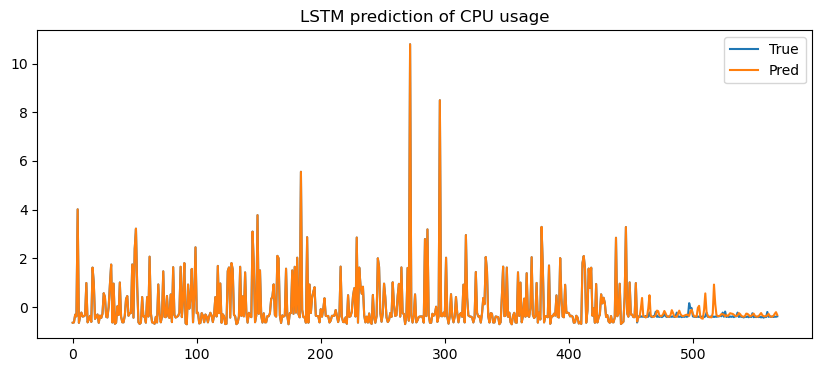

LSTM MSE: 0.0103
LSTM MAE: 0.0241


In [8]:
model.eval()
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        preds.append(pred)
        trues.append(yb.numpy())
preds = np.concatenate(preds).flatten()
trues = np.concatenate(trues).flatten()
# preds = preds * std + mean
# trues = trues * std + mean
common_data = []
# print(len(trues), len(preds))
for xb, yb in train_loader:
    common_data.append(yb.numpy())
common_data = np.concatenate(common_data).flatten()
preds = np.concatenate([common_data, preds])
trues = np.concatenate([common_data, trues])
# trues = common_data + trues
plt.figure(figsize=(10,4))

plt.plot(trues, label='True')
plt.plot(preds, label='Pred')
plt.legend()
plt.title('LSTM prediction of CPU usage')
plt.show()
lstm_mse = np.mean((preds - trues) ** 2)
print(f"LSTM MSE: {lstm_mse:.4f}")
lstm_mae = np.mean(np.abs(preds - trues))
print(f"LSTM MAE: {lstm_mae:.4f}")

In [9]:
def select_best_arima_order(y_train, max_p=5, max_d=2, max_q=5):
    best_aic = np.inf
    best_order = None
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = sm.tsa.ARIMA(y_train, order=(p, d, q), trend='n')
                    result = model.fit(method_kwargs={'maxiter':300})
                    if result.aic < best_aic:
                        best_aic = result.aic
                        best_order = (p, d, q)
                except:
                    continue
    return best_order

arima_order = select_best_arima_order(y_train, max_p=5, max_d=2, max_q=5)
arima_training_start_time = time()
arima_model = sm.tsa.ARIMA(y_train, order=arima_order, trend='n')
arima_result = arima_model.fit(method_kwargs={'maxiter':300})
arima_training_end_time = time()
# Print training time
print(f"ARIMA training time: {arima_training_end_time - arima_training_start_time:.2f} seconds")

/home/zlp/miniconda3/envs/workload_prediction/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zlp/miniconda3/envs/workload_prediction/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA training time: 1.12 seconds


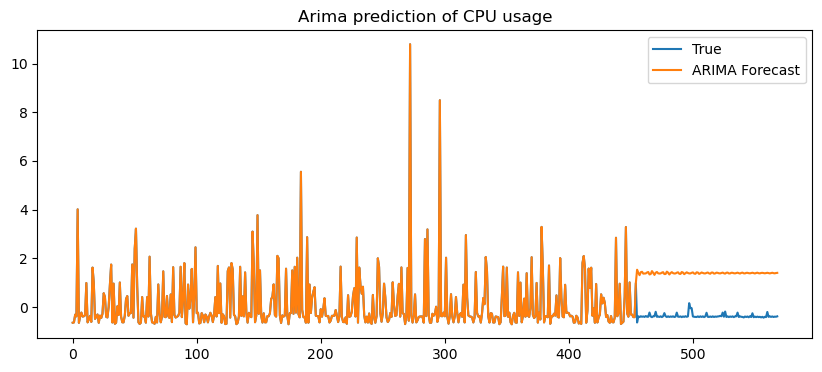

ARIMA MSE: 0.6288
ARIMA MAE: 0.3544


In [10]:
forecast = arima_result.forecast(steps=len(y_test))
forecast = forecast * std + mean  # 反标准化
y_test_standard = y_test
# y_test_standard = np.array(y_test) * std + mean  # 反标准化
forecast = np.concatenate([common_data, forecast])  # 合并预测结果
y_test_standard = np.concatenate([common_data, y_test_standard])  # 合并测试结果
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(y_test_standard)), y_test_standard, label='True')
plt.plot(np.arange(len(forecast)), forecast, label='ARIMA Forecast')
plt.legend()
plt.title('Arima prediction of CPU usage')
plt.show()
arima_mse = np.mean((forecast - y_test_standard) ** 2)
print(f"ARIMA MSE: {arima_mse:.4f}")
arima_mae = np.mean(np.abs(forecast - y_test_standard))
print(f"ARIMA MAE: {arima_mae:.4f}")

In [ ]:
import models.Informer as Informer
# 初始化Informer模型
input_size = 1  # 特征数量
embed_size = 64  # 嵌入维度
hidden_size = 64  # 隐藏层神经元数量
num_layers = 2  # 编码器层数
num_heads = 4  # 自注意力的头数
forecast_horizon = 1  # 预测的目标步长

model = Informer(input_size, embed_size, hidden_size, num_layers, num_heads, forecast_horizon).to(device)

# 定义训练函数
def train_model_with_dataloader(model, train_loader, test_loader, epochs=50, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_loss = []
    val_loss = []
    
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        train_loss.append(epoch_train_loss / len(train_loader))
        
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                epoch_val_loss += loss.item()
        
        val_loss.append(epoch_val_loss / len(test_loader))
        
        if (epoch + 1) % 10 == 0:  # 每10个epoch输出一次结果
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}')
    
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 训练模型
informer_training_start_time = time()
train_model_with_dataloader(model, train_loader, test_loader, epochs=500)
informer_training_end_time = time()
# Print training time
print(f"Informer training time: {informer_training_end_time - informer_training_start_time:.2f} seconds")
# 评估模型
def evaluate_model_with_dataloader(model, test_loader):
    model.eval()
    y_pred_list = []
    y_test_list = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            y_pred_list.append(y_pred.cpu().numpy())
            y_test_list.append(y_batch.cpu().numpy())
    
    y_pred_rescaled = np.concatenate(y_pred_list, axis=0)
    y_test_rescaled = np.concatenate(y_test_list, axis=0)
    
    # mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mse = np.mean((y_test_rescaled - y_pred_rescaled) ** 2)
    print(f'Mean Absolute Error: {np.mean(np.abs(y_test_rescaled - y_pred_rescaled)):.4f}')
    print(f'Mean Absolute Percentage Error: {np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100:.2f}%')
    print(f'Mean Squared Error: {mse:.4f}')
    # y_pred_rescaled = y_pred_rescaled * std + mean  # 反标准化
    # y_test_rescaled = y_test_rescaled * std + mean  # 反标准化
    plt.figure(figsize=(10, 4))
    print(common_data.shape, y_pred_rescaled.shape, y_test_rescaled.shape)
    y_pred_rescaled = np.concatenate([common_data, y_pred_rescaled.squeeze()])  # 合并预测结果
    y_test_rescaled = np.concatenate([common_data, y_test_rescaled.squeeze()])  # 合并测试结果
    plt.plot(y_test_rescaled, label='True')
    plt.plot(y_pred_rescaled, label='Predicted')
    plt.legend()
    plt.title('Informer prediction of CPU usage')
    plt.show()
   
    return y_pred_rescaled, y_test_rescaled

# 评估模型性能
y_pred_rescaled, y_test_rescaled = evaluate_model_with_dataloader(model, test_loader)

NameError: name 'Informer' is not defined